# Examine Local Entropy of and Conditional Entropy of Wired Examples
*******************

TODO:
- clean wired text
- conditional entropy calculation
- implement continuous entropy approx
- different datasets

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [2]:
# load model 
# https://huggingface.co/transformers/v4.8.2/_modules/transformers/models/gpt2/modeling_gpt2.html
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [3]:
# tokenizer example
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
tokenizer.decode(encoded_input['input_ids'][0])

"Replace me by any text you'd like."

In [4]:
# model example
# https://huggingface.co/transformers/v4.8.2/main_classes/output.html?highlight=causallmoutputwithcrossattentions#transformers.modeling_outputs.CausalLMOutputWithCrossAttentions
output = model(**encoded_input)
print(output.logits.shape)
best = torch.argmax(output.logits, dim=2)
tokenizer.decode(best[0])

torch.Size([1, 10, 50257])


'. the with a means, want like.\n'

In [15]:
# functions for local entropy calculation'

def word_entropy(logits, k):
    """entropy of conditinal distribution over each word"""
    logits = torch.topk(logits, k).values # approx distribution using top k words
    logits = logits.detach().numpy().astype(np.longdouble)
    p = 1/(1 + np.exp(-logits))
    p = p / p.sum(axis=2, keepdims=True) # rescale distribution
    entropy = (-p*np.log(p)).sum(axis=2)
    return entropy

def word_entropy_cont(logits, k=500):
    """entropy of conditinal distribution over each word assuming power law probability distribution"""
    pass

def local_entropy(logits, k=500, n=5):
    """average word entropy, ignoring first n words"""
    we = word_entropy(logits, k)
    return we[0][n:].mean() if len(we[0][n:])>0 else None

In [10]:
from pathlib import Path
import re

# text loading / preprocessing
def get_text(level, episode, season, seq_len=700, overlap=20):
    # load text
    file = f"wired_transcript/s{season}e{episode}/{level}.txt"
    txt = Path(file).read_text()
    
    # clean text
    txt = re.sub('\n', ' ', txt)
    txt_arry = txt.split()
    # chunk and return
    chunks = []
    i = 0
    while i<len(txt_arry):
        chunks.append(' '.join(txt_arry[i:i+seq_len]))
        i += seq_len - overlap
    return chunks

get_text(1,1,1)

["do you know why we're here today because we're talking about science yes we're going to talk about science and we're going to talk about a very specific kind of science about people who study brains do you know what a brain is what is it things um so what we're going to talk about this is something that people study in the brain called the connect tone do you know that your body is made up of really tiny things called cells um yes okay well there's more cells in your brain like way more cells than than all the stars we can see and so what the connectome is is we'd like to know where every cell in your brain is and how it talks to every other cell in your brain that was awesome daniel thank you"]

*************
### local entropy vs. level

In [16]:
# compute local entropy for each level of each episode
episodes = [(e+1,1) for e in range(20)]

hist = []
for e, s in episodes: # for each episode
    print(f'episode {e}', end='\r')
    ep_ents = []
    for lvl in range(5): # for each level
        txts = get_text(lvl+1, e, 1)
        ent, n = 0, 0
        for txt in txts: # chunked text
            logits = model(**tokenizer(txt, return_tensors='pt')).logits # get word logits
            le = local_entropy(logits) # get local entropy
            if le:
                ent += le
                n += 1
        ep_ents.append(ent/n)
    hist.append(ep_ents)

0.04129127904530416


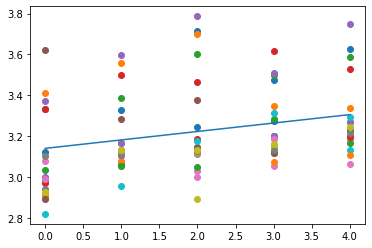

In [17]:
# plot results
fig, ax = plt.subplots()

# get best fit line
x, y = [], []
for ep in hist[:-1]:
    for i in range(5):
        x.append((i, 1))
        y.append(ep[i])
m, c = np.linalg.lstsq(np.array(x).astype(float), np.array(y).astype(float), rcond=None)[0]
print(m)

# data points
x = np.arange(5)
for ep in hist:
    ax.scatter(x, ep)
# best fit line
ax.plot(x, m*x+c)
    
plt.show()